# Experiments 5

Observe the impacts of land-use policy to the suitability of each land-use class.

- Policies: 11 original Waas policies + Zoning policy
- Climate change scenarios: Yes
- Socioeconomic scenarios: Yes

In [1]:
from ema_workbench import load_results
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

results = load_results('S07_26022018_v174.tar.gz')
experiments, outcomes = results

#outcomes df
outcomes_df = pd.DataFrame.from_dict(outcomes)
outcomes_df['integrator'] = outcomes_df.index

#experiments df
experiments_df = pd.DataFrame(experiments)
experiments_df['integrator'] = experiments_df.index

#results df
results_df = pd.merge(outcomes_df, experiments_df, on='integrator')

results_df['zoning'] = results_df['policy'].apply(lambda x: 'Zoning' if '+Z' in x else 'NoZoning')
results_df['policy'] = results_df['policy'].apply(lambda x: x.strip('+Z'))

C:\Users\bjafino\anaconda3\envs\py27\lib\site-packages\ema_workbench\em_framework\optimization.py:22: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


In [2]:
parcoords_df =results_df.groupby(['policy', 'zoning'])[['ATP_i', 'DRFlooded_i', 'DamAgriKSum_i', 'DamCumFloat_i', 'StadFldA_i',
                                                            'agriSuit_i', 'greeSuit_i', 'natuSuit_i', 'recrSuit_i', 'resiSuit_i',
                                                            'workSuit_i']].median()
parcoords_df['policy'] = parcoords_df.index
parcoords_df['policy'] = parcoords_df['policy'].astype('category')

#rearrange columns order
cols = list(parcoords_df.columns.values)
cols.pop(cols.index('policy'))
parcoords_df = parcoords_df[cols+['policy']]

# parcoords_df = parcoords_df[:-1]
zoning_df = parcoords_df.loc[pd.IndexSlice[:, 'Zoning'], :]
noZoning_df = parcoords_df.loc[pd.IndexSlice[:, 'NoZoning'], :]

for df in [zoning_df, noZoning_df]:
    df.index = df.index.droplevel(level=-1)
    df['policy'] = df.index
    
#subset land-use suitability indicators
lu_suitability_list = [ u'agriSuit_i', u'greeSuit_i', u'recrSuit_i', u'resiSuit_i',u'workSuit_i', u'policy']
zoning_suitability_df = zoning_df[lu_suitability_list]
noZoning_suitability_df = noZoning_df[lu_suitability_list]

C:\Users\bjafino\anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
reindex_policy = ['NoPol', 'DH500', 'DH1000', 'DH1.5', 'RfRSmall', 'RfRMed', 'RfRLarge', 'CopU', 'FloatH', 'FaC', 'Mound']
zoning_suitability_df = zoning_suitability_df.reindex(reindex_policy)

In [4]:
noZoning_suitability_df = noZoning_suitability_df.reindex(reindex_policy)

In [5]:
def normalize(x, df):
    for item in x:
        c = list(df[item])
        df[item] = (df[item]-np.min(df[item])) / (np.max(df[item])-np.min(df[item]))

In [6]:
suitability_list = ['agriSuit_i', 'greeSuit_i', 'recrSuit_i', 'resiSuit_i','workSuit_i']

normalize(x = suitability_list, df=noZoning_suitability_df)
normalize(x = suitability_list, df=zoning_suitability_df)

In [7]:
zoning_suitability_df['zoning'] = 'Zoning'
noZoning_suitability_df['zoning'] = 'NoZoning'

all_suitability_df = zoning_suitability_df.append(noZoning_suitability_df)
all_suitability_df.index = range(len(all_suitability_df))
all_suitability_df.columns = ['agriculture', 'greenhouse', 'recreation', 'residential', 'indsutry', 'policy', 'zoning']

In [8]:
def set_ticks_for_axis(dim, ax, ticks, min_max_range, cols, df2, objective, num):
    min_val, max_val, val_range = min_max_range[cols[dim]]
    step = val_range / float(ticks-1)
    tick_labels = [round(min_val + step * i, 2) for i in range(ticks)]
    norm_min = df2[cols[dim]].min()
    norm_range = np.ptp(df2[cols[dim]])
    norm_step = norm_range / float(ticks-1)
    ticks = [round(norm_min + norm_step * i, 2) for i in range(ticks)]
    if len(objective) > 0:
        if objective[num]=='MIN':
            ticks = [tick for tick in reversed(ticks)]
    ax.yaxis.set_ticks(ticks)
    ax.set_yticklabels(tick_labels)
    
def parcoords_compare2(df, col):
    df2 = df.copy()
    
    cols = list(df2.columns[:-2])
    x = [i for i, _ in enumerate(cols)]
    col_list = list(set(df2[col]))
    colours = ['sandybrown', 'lightskyblue']

    # create dict of categories: colours
    colours = {col_list[i]: colours[i] for i, _ in enumerate(col_list)}
    # Create (X-1) sublots along x axis
    fig, axes = plt.subplots(1, len(x)-1, sharey=False, figsize=(15,5))

    # Get min, max and range for each column
    # Normalize the data for each column
    min_max_range = {}
    for j, col in enumerate(cols):
        min_max_range[col] = [df2[col].min(), df2[col].max(), np.ptp(df2[col])]
        df2[col] = np.true_divide(df2[col] - df2[col].min(), np.ptp(df2[col]))
        
    # Plot each row
    for i, ax in enumerate(axes):
        for idx in df2.index:
            mpg_category = df2.iloc[idx,-1]
            ax.plot(x, df2.loc[idx, cols], colours[mpg_category])
        ax.set_xlim([x[i], x[i+1]])

    for dim, ax in enumerate(axes):
        ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
        set_ticks_for_axis(dim, ax, ticks=6, min_max_range=min_max_range, cols=cols, df2=df2, objective=[], num=dim)
        ax.set_xticklabels([cols[dim]])
        
        if len(x) < 8:
            ax.xaxis.set_tick_params(labelsize=13)


    # Move the final axis' ticks to the right-hand side
    ax = plt.twinx(axes[-1])
    dim = len(axes)
    ax.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
    set_ticks_for_axis(dim, ax, ticks=6, min_max_range=min_max_range, cols=cols, df2=df2, objective=[], num=-1)
    ax.set_xticklabels([cols[-2], cols[-1]])
    
    # Remove space between subplots
    plt.subplots_adjust(wspace=0)

    # Add legend to plot
    plt.legend(
        [plt.Line2D((0,1),(0,0), color=colours[cat]) for cat in col_list],
        col_list, fontsize=15,
        bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

    plt.title("")

    return plt

<module 'matplotlib.pyplot' from 'C:\Users\bjafino\anaconda3\envs\py27\lib\site-packages\matplotlib\pyplot.pyc'>

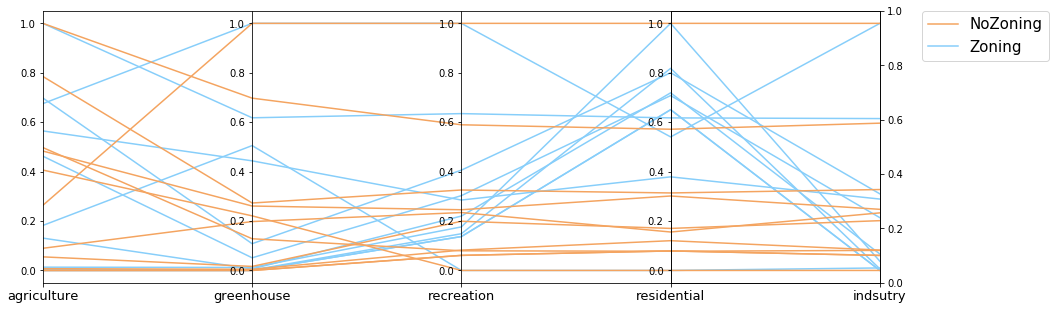

In [9]:
parcoords_compare2(df=all_suitability_df, col='zoning')